In [9]:
import os
import re
import numpy as np
from scipy.spatial.distance import pdist, squareform, cdist, cosine, jensenshannon
import seaborn as sns
from bert_serving.client import BertClient
import matplotlib.pyplot as plt
import pandas as pd
import unicodedata
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from matplotlib import pyplot as plt
import seaborn as sns
from collections import Counter
import artm
from nltk.corpus import stopwords 
from pymystem3 import Mystem
from tqdm.auto import tqdm
import pickle

russian_stopwords = set(stopwords.words("russian"))
m = Mystem()
m._mystemargs = ['--format', 'json', '-gidwc']


In [2]:
def chunks(lst, n):
    for i in range(0, len(lst), n):
        yield lst[i:i + n]

In [3]:
def text_to_chunks(text, words_in_chunk=1024, min_chunk_size=500):
    tokens = text.split(' ')
    n_chunks = len(tokens) // words_in_chunk
    return list(' '.join(ch) for ch in chunks(tokens, words_in_chunk) 
                if len(ch) > min_chunk_size)

In [4]:
def chunk_to_sentences(text_chunk, max_sentence_size=128):
    return list(' '.join(ch) for ch in chunks(text_chunk.split(), max_sentence_size))

In [5]:
def text_to_sentences(text):
    return [s for chunk in text_to_chunks(text) for s in chunk_to_sentences(chunk)]

In [6]:
def process_texts(texts):
    data = []
    for i, text in enumerate(texts):
        for j, chunk in enumerate(text_to_chunks(text)):
            for sent in chunk_to_sentences(chunk):
                data.append((i, j, sent))
    return pd.DataFrame(data, columns=['book', 'chunk', 'sentence'])

In [7]:
def normalize_text(text):
    text = unicodedata.normalize("NFKC", text).strip()
    text = text.replace('?..', '?')
    text = text.replace('!..', '!')
    text = text.replace('...', '…')
    text = text.replace('--', '–')
    text = re.sub('[…]+', ' … ', text)
    text = re.sub('[_]+', '_', text)
    text = re.sub('[\n]+', ' \n ', text)
    text = re.sub('[*]+', '*', text)
    return text

In [13]:
bc = BertClient()

In [47]:
polka_texts = []
for f in sorted(os.listdir('../pb-stylistic/txt_cut/')):
    with open('../pb-stylistic/txt_cut/' + f) as fi:
        polka_texts.append(normalize_text(fi.read()))

In [9]:
polka_data = process_texts(polka_texts)

In [17]:
%%time
polka_data['bert'] = list(bc.encode(polka_data['sentence'].tolist()))

CPU times: user 3.66 s, sys: 1.07 s, total: 4.73 s
Wall time: 6h 10min 4s


In [48]:
ridero_texts = []
for f in sorted(os.listdir('ridero_books'))[:]:
    with open('ridero_books/' + f) as fi:
        ridero_texts.append(normalize_text(fi.read()))

In [11]:
ridero_data = process_texts(ridero_texts)

In [18]:
%%time
ridero_data['bert'] = list(bc.encode(ridero_data['sentence'].tolist()))

CPU times: user 4.88 s, sys: 1.67 s, total: 6.55 s
Wall time: 4h 20min 49s


In [126]:
ridero_chunks = ridero_data.groupby(['book', 'chunk'])['bert'].apply(lambda x: x.mean(axis=0)).reset_index()

In [13]:
polka_chunks = polka_data.groupby(['book', 'chunk'])['bert'].apply(lambda x: x.mean(axis=0)).reset_index()

In [322]:
x1 = np.stack(ridero_chunks.groupby('book')['bert'].apply(lambda x: x[-1]).values[:10])
x2 = np.stack(polka_chunks['bert'].values)
d = cdist(x1, x2, metric=cosine)
d.argsort()[:, :3]

In [398]:
for j in range(10):
    ridero_text = ridero_data \
        .groupby(['book', 'chunk'])['sentence'] \
        .apply(lambda x: ' '.join(x)) \
        .groupby('book') \
        .apply(lambda x: x[-1]) \
        .iloc[i]
    with open(f'bert_pairs/ridero_{j}.txt', 'w') as f:
        f.write(ridero_text)
    for i, top in enumerate(d.argsort()[i, :3]):
        polka_text = polka_data.groupby(['book', 'chunk'])['sentence'].apply(lambda x: ' '.join(x)).iloc[top]
        with open(f'bert_pairs/ridero_{j}_top{i}_{top}.txt', 'w') as f:
            f.write(polka_text)
        

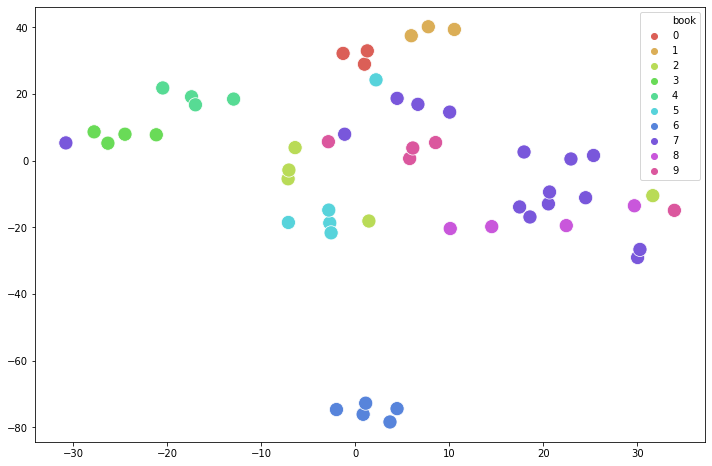

In [448]:
# chunks, chunk = 1x768 embed
plt.figure(figsize=(12,8))
tsne = TSNE(n_components=2, verbose=0, perplexity=5, n_iter=2000, learning_rate=50, random_state=33)
r = tsne.fit_transform(np.stack(ridero_chunks['bert'].values))
sns.scatterplot(
    x=r[:, 0], y=r[:, 1],
    palette=sns.color_palette("hls", 10),
    legend="full",
    hue=ridero_chunks.book,
    s=200
)

In [325]:
d2 = cdist(np.stack(ridero_chunks['bert'].values), x2, metric=cosine)

In [ ]:
chunk -> encoded(chunk) -> dist ( encoded_chunk, encoded_polka_chunk_i)

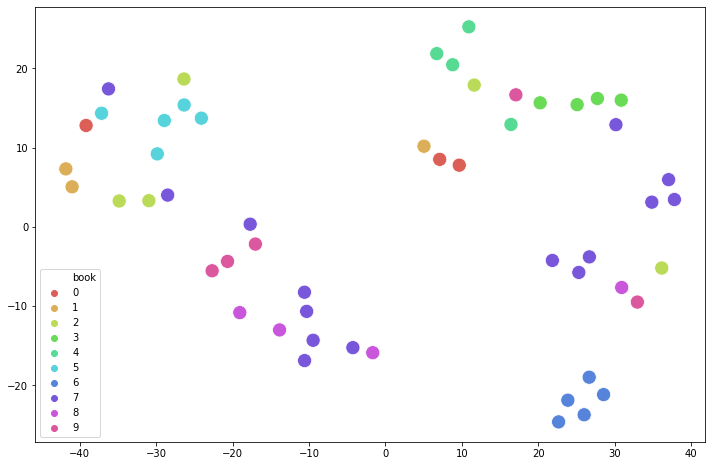

In [436]:
# chunks' dists to 6k ridero chunks (cos)
plt.figure(figsize=(12,8))
tsne = TSNE(n_components=2, verbose=0, perplexity=5, n_iter=2000, learning_rate=50, random_state=33)
r = tsne.fit_transform(d2)
sns.scatterplot(
    x=r[:, 0], y=r[:, 1],
    palette=sns.color_palette("hls", 10),
    legend="full",
    hue=ridero_chunks.book,
    s=200
)

In [14]:
dd = np.array(list(ridero_chunks['bert'].values) + list(polka_chunks['bert'].values))

In [15]:
h = [0] * len(ridero_chunks) + [1] * len(polka_chunks)

In [16]:
len(h)

14338

5


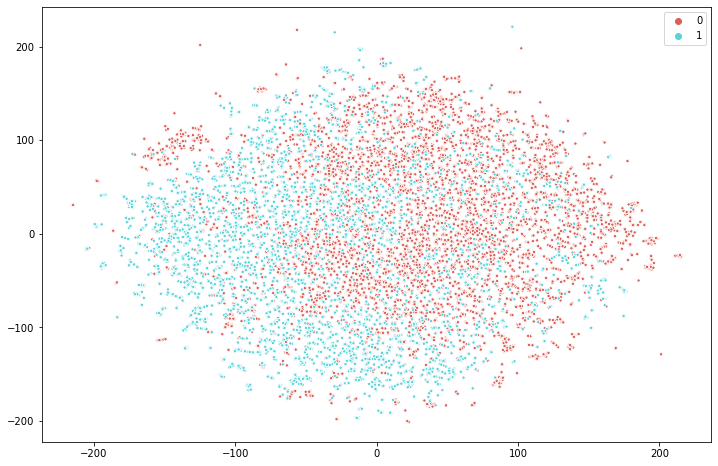

20


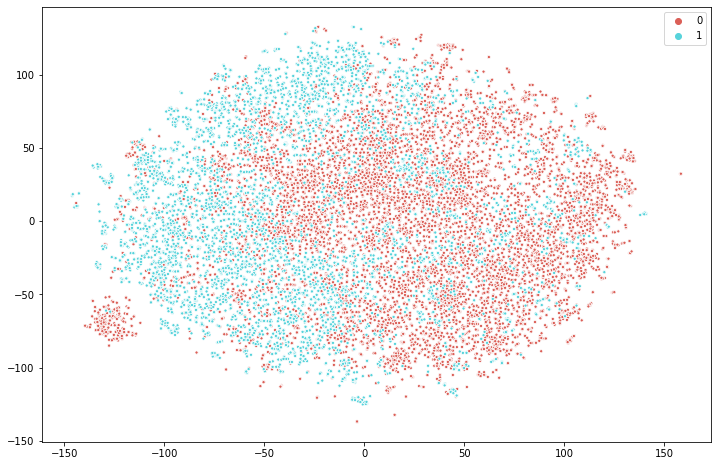

50


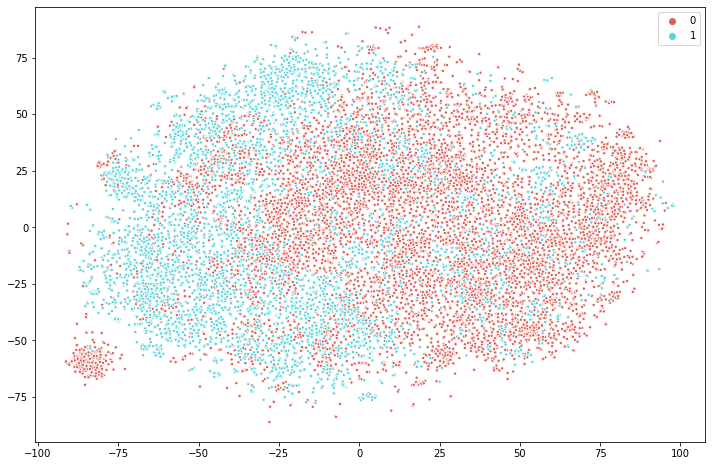

100


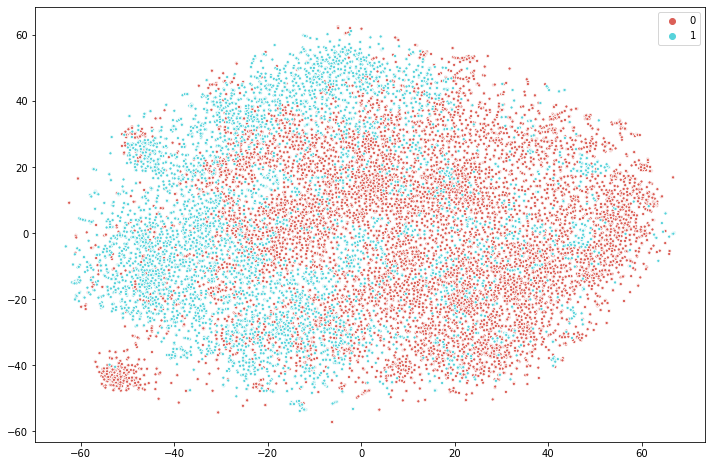

CPU times: user 1h 1min 44s, sys: 38.6 s, total: 1h 2min 22s
Wall time: 1h 2min 20s


In [17]:
%%time
perplexity = [5, 20, 50, 100]
for p in perplexity:
    tsne = TSNE(n_components=2, verbose=0, perplexity=p, n_iter=5000, learning_rate=50, random_state=33)
    r = tsne.fit_transform(dd)
    print(p)
    plt.figure(figsize=(12,8))
    sns.scatterplot(
        x=r[:, 0], y=r[:, 1],
        palette=sns.color_palette("hls", 2),
    #     legend="full",
        hue=h,
        s=10
    )
    plt.show()

In [ ]:
7

In [18]:
len(polka_chunks), len(ridero_chunks)

(5398, 8940)

In [518]:
r_uniq_b = ridero_chunks.book.unique()
p_uniq_b = polka_chunks.book.unique()
# gdr = []
# for rb in r_uniq_b:
#     r_ch = np.stack(ridero_chunks[ridero_chunks.book==rb]['bert'])
#     for pb in p_uniq_b:
#         p_ch = np.stack(ridero_chunks[ridero_chunks.book==rb]['bert'])

In [519]:
A = [np.stack(ridero_chunks[ridero_chunks.book==rb]['bert']) for rb in r_uniq_b]
B = [np.stack(polka_chunks[polka_chunks.book==pb]['bert']) for pb in p_uniq_b]

In [520]:
%%time
gdr = []
for a in A:
    dr = []
    for b in B:
        dr.append(cdist(a, b, metric='cosine').mean())
    gdr.append(dr)

CPU times: user 29.1 s, sys: 26.7 ms, total: 29.1 s
Wall time: 29.1 s


In [ ]:
book -> [chunk, ..]
book2 -> [chunk, ..]

ridero_book = 1x620


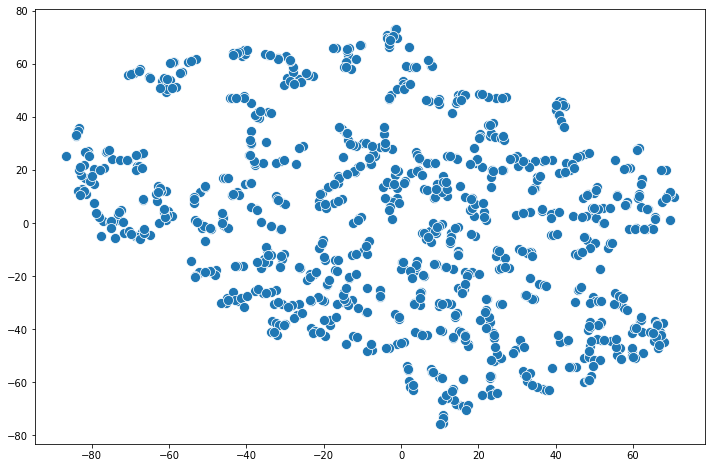

In [543]:
plt.figure(figsize=(12,8))
tsne = TSNE(n_components=2, verbose=0, perplexity=5, n_iter=1000, learning_rate=50, random_state=17)
r = tsne.fit_transform(gdr)
sns.scatterplot(
    x=r[:, 0], y=r[:, 1],
#     palette=sns.color_palette("hls", 10),
#     legend="full",
#     hue=ridero_chunks.book,
    s=100
)

In [544]:
%%time
gdrmin = []
for a in A:
    dr = []
    for b in B:
        dr.append(cdist(a, b, metric='cosine').min())
    gdrmin.append(dr)

CPU times: user 45.6 s, sys: 105 ms, total: 45.7 s
Wall time: 45.8 s


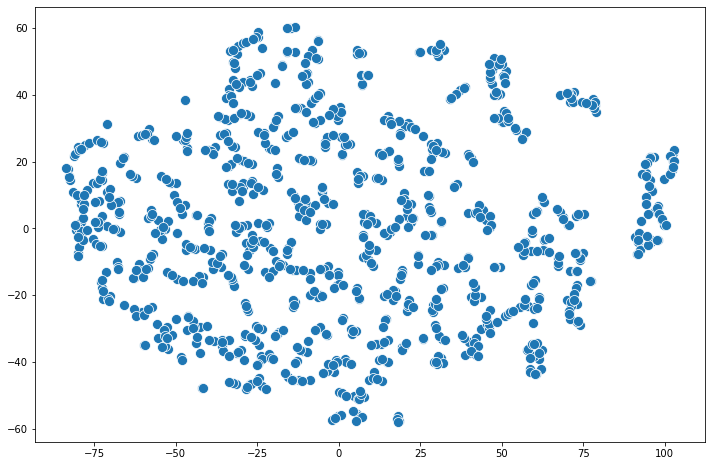

In [554]:
plt.figure(figsize=(12,8))
tsne = TSNE(n_components=2, verbose=0, perplexity=5, n_iter=1000, learning_rate=50, random_state=33, init='pca')
r = tsne.fit_transform(gdrmin)
sns.scatterplot(
    x=r[:, 0], y=r[:, 1],
#     palette=sns.color_palette("hls", 10),
#     legend="full",
#     hue=ridero_chunks.book,
    s=100
)

In [32]:
7

7

In [34]:
with open('test_final/ridero_data.pkl', 'wb') as f:
    pickle.dump(ridero_data, f)
with open('test_final/polka_data.pkl', 'wb') as f:
    pickle.dump(polka_data, f)

In [10]:
with open('test_final/ridero_data.pkl', 'rb') as f:
    ridero_data = pickle.load(f)
with open('test_final/polka_data.pkl', 'rb') as f:
    polka_data = pickle.load(f)

In [12]:
polka_data

book  chunk                                           sentence  \
0         0      0  Звонок был настырным, долгим, как паровозный г...   
1         0      0  Тетя Лида-покойница, она не нам приходится род...   
2         0      0  горячись, сказала она себе, никто не собирался...   
3         0      0  случай? И Маша зачем-то записала, чтобы не оби...   
4         0      0  своим производным, истаивало в небытии … Вдруг...   
...     ...    ...                                                ...   
42758   620      9  у нас в дому не утонул, а что гулеванила, бере...   
42759   620      9  полу, на потрескавшихся подоконниках – везде, ...   
42760   620      9  сказала Богодулу: – Ну вот, напились мы с тобо...   
42761   620      9  чему идти туда с нетвердой душой, смущать поко...   
42762   620      9  вдали, спадая ровно и аккуратно; левый рукав, ...   

                                                    bert  
0      [0.0964424, 0.19305643, -0.2271955, 0.25281447...  
1      [0.13502505, 0.25914422, -0.30103672, 0.309272...  
2      [0.16413973, 0.100658074, -0.49719083, 0.34344...  
3      [0.2542588, 0.102879085, -0.18399607, 0.412786...  
4      [0.24586025, 0.27572727, -0.19973311, 0.423513...  
...                                                  ...  
42758  [0.20956467, 0.2811545, -0.59341574, 0.3675131...  
42759  [0.51701325, 0.033594314, -0.26917, 0.46789595...  
42760  [0.26559407, 0.19705969, -0.5999197, 0.3856214...  
42761  [0.23917863, 0.1773024, -0.411602, 0.43701926,...  
42762  [0.078323066, -0.11916521, 0.19680189, 0.57479...  

[42763 rows x 4 columns]

In [13]:
def topic_model_processor(text):
    return mystem_processor(text)

In [14]:
def mystem_processor(text):
    parsed = m.analyze(text)
    tokens = []
    for w in parsed:
        try:
            anal = w['analysis'][0]
            gr = anal['gr']
            lex = anal['lex']
            if 'имя,' in gr or 'фам,' in gr or 'отч,' in gr:
                raise
            if lex in russian_stopwords:
                raise
            if not gr.startswith(('S,', 'S=')):
                raise
            if len(lex) < 3:
                raise
            tokens.append(lex)
        except:
            continue
    return ' '.join(tokens)

In [15]:
def process_chunks_from_dataframe(df, processor=None):
    return df.groupby(['book', 'chunk'])['sentence'] \
            .apply(lambda x: processor(' '.join(x)))

In [16]:
%%time
polka_chunks_processed = process_chunks_from_dataframe(polka_data, topic_model_processor)

ridero_chunks_processed = process_chunks_from_dataframe(ridero_data, topic_model_processor)

CPU times: user 49.2 s, sys: 863 ms, total: 50.1 s
Wall time: 10min 2s


In [17]:
model = artm.load_artm_model(f'S_maxdf6_100_400_prolly_best')
model.reshape_topics([f'topic_{i}' for i in range(100, 500)])

In [18]:
key = lambda x: [int(s) for s in x.split('_')]

In [19]:
# POLKA
for ind, text in zip(polka_chunks_processed.index, polka_chunks_processed.values):
    name = '_'.join([*map(str, ind) ])
    with open('test_final/processed_chunks_for_tm_polka/' + name, 'w') as f:
        f.write(text)

# RIDERO
for ind, text in zip(ridero_chunks_processed.index, ridero_chunks_processed.values):
    name = '_'.join([*map(str, ind) ])
    with open('test_final/processed_chunks_for_tm_ridero/' + name, 'w') as f:
        f.write(text)

In [20]:
# POLKA
with open('test_final/artm data/wv_polka.txt', 'w') as f1:
    folder = 'test_final/processed_chunks_for_tm_polka'
    for name in sorted(os.listdir(folder), key=key):
        with open(folder + '/' + name) as doc:
            tokens = doc.read().replace('?', '').replace('\n', ' ').split()
            doc_voc = Counter(tokens)
            s = ' '.join(f'{w}:{c}' for w, c in sorted(doc_voc.items()))
            row = f'{name} {s}\n'
            f1.write(row)

# RIDERO
with open('test_final/artm data/wv_ridero.txt', 'w') as f1:
    folder = 'test_final/processed_chunks_for_tm_ridero'
    for name in sorted(os.listdir(folder), key=key):
        with open(folder + '/' + name) as doc:
            tokens = doc.read().replace('?', '').replace('\n', ' ').split()
            doc_voc = Counter(tokens)
            s = ' '.join(f'{w}:{c}' for w, c in sorted(doc_voc.items()))
            row = f'{name} {s}\n'
            f1.write(row)

In [21]:
# POLKA
polka_batch_vectorizer = artm.BatchVectorizer(
    data_path=f'test_final/artm data/wv_polka.txt',
    data_format='vowpal_wabbit',
    target_folder=f'test_final/artm data/polka batches')

# RIDERO
ridero_batch_vectorizer = artm.BatchVectorizer(
    data_path=f'test_final/artm data/wv_ridero.txt',
    data_format='vowpal_wabbit',
    target_folder=f'test_final/artm data/ridero batches')

In [22]:
ridero_topics = model.transform(ridero_batch_vectorizer).T.sort_index()
ridero_topics.index = ridero_chunks_processed.index

In [23]:
polka_topics = model.transform(polka_batch_vectorizer).T.sort_index()
polka_topics.index = polka_chunks_processed.index

In [24]:
ridero_topics.to_csv('test_final/ridero_topics.csv')
polka_topics.to_csv('test_final/polka_topics.csv')

In [25]:
ridero_topics

topic_100  topic_101  topic_102  topic_103  topic_104  topic_105  \
book chunk                                                                     
0    0       0.000000   0.000000   0.000000        0.0        0.0   0.000000   
     1       0.000000   0.005495   0.000000        0.0        0.0   0.000000   
     2       0.000000   0.016667   0.000000        0.0        0.0   0.000000   
1    0       0.000000   0.000000   0.000000        0.0        0.0   0.000000   
     1       0.000000   0.000000   0.000000        0.0        0.0   0.000000   
...               ...        ...        ...        ...        ...        ...   
1924 0       0.016393   0.000000   0.000000        0.0        0.0   0.000000   
     1       0.000000   0.000000   0.000000        0.0        0.0   0.000000   
     2       0.027625   0.000000   0.000000        0.0        0.0   0.007923   
     3       0.014706   0.000000   0.000000        0.0        0.0   0.000000   
     4       0.007519   0.000000   0.007519        0.0        0.0   0.000000   

            topic_106  topic_107  topic_108  topic_109  ...  topic_490  \
book chunk                                              ...              
0    0       0.004218   0.000000   0.000000        0.0  ...        0.0   
     1       0.016484   0.000000   0.000000        0.0  ...        0.0   
     2       0.000000   0.000000   0.000000        0.0  ...        0.0   
1    0       0.000000   0.000000   0.012987        0.0  ...        0.0   
     1       0.000000   0.000000   0.000000        0.0  ...        0.0   
...               ...        ...        ...        ...  ...        ...   
1924 0       0.000000   0.000000   0.000000        0.0  ...        0.0   
     1       0.000000   0.048276   0.000000        0.0  ...        0.0   
     2       0.000000   0.000000   0.000000        0.0  ...        0.0   
     3       0.000000   0.000000   0.000000        0.0  ...        0.0   
     4       0.000000   0.022866   0.000000        0.0  ...        0.0   

            topic_491  topic_492  topic_493  topic_494  topic_495  topic_496  \
book chunk                                                                     
0    0       0.000000   0.000000   0.003937   0.000000   0.004109   0.000000   
     1       0.000000   0.000000   0.005495   0.000000   0.005495   0.000000   
     2       0.005556   0.000000   0.027778   0.000000   0.016667   0.000000   
1    0       0.000000   0.000000   0.000000   0.000000   0.000000   0.000000   
     1       0.000000   0.000000   0.000000   0.000000   0.000000   0.000000   
...               ...        ...        ...        ...        ...        ...   
1924 0       0.000000   0.005464   0.016393   0.005464   0.000000   0.000000   
     1       0.000000   0.020690   0.000000   0.000000   0.025155   0.000000   
     2       0.005236   0.005236   0.000000   0.000000   0.000000   0.000000   
     3       0.000000   0.000000   0.004902   0.000000   0.000000   0.000000   
     4       0.000000   0.022556   0.000000   0.000000   0.000000   0.007519   

            topic_497  topic_498  topic_499  
book chunk                                   
0    0       0.011811   0.003937        0.0  
     1       0.000000   0.000000        0.0  
     2       0.072222   0.000000        0.0  
1    0       0.000000   0.000000        0.0  
     1       0.000000   0.000000        0.0  
...               ...        ...        ...  
1924 0       0.005464   0.000000        0.0  
     1       0.000000   0.000000        0.0  
     2       0.005236   0.005236        0.0  
     3       0.000000   0.000000        0.0  
     4       0.000000   0.007519        0.0  

[8940 rows x 400 columns]

In [36]:
%%time
cd = cdist(ridero_topics, polka_topics, metric=jensenshannon)

CPU times: user 40min 14s, sys: 1min 46s, total: 42min
Wall time: 37min 47s


In [37]:
with open('test_final/topic_dists', 'wb') as f:
    pickle.dump(cd, f)

In [ ]:
with open('test_final/topic_dists', 'rb') as f:
    cd = pickle.load(f)

In [364]:
# (ridero_chunk_index, polka_chunk_index)
pairs = np.unravel_index(cd.ravel().argpartition(10)[:10], cd.shape)

In [365]:
sorted(cd[pairs])

[0.45051361634269044,
 0.4756290963966557,
 0.4917093149408051,
 0.4994959454718827,
 0.5011484117649049,
 0.5011569537066168,
 0.5017925556027582,
 0.5034843083751249,
 0.5057837501458601,
 0.509748149779606]

In [38]:
pairs = np.unravel_index(cd.ravel().argpartition(10)[:10], cd.shape)
sorted(cd[pairs])

[0.4406443269461088,
 0.4527645244116587,
 0.4698894744368951,
 0.4782087583755058,
 0.4782706756554896,
 0.4789875587431456,
 0.485279707592549,
 0.489443347953544,
 0.48957005552826394,
 0.49358455804655754]

In [39]:
pairs

(array([6124, 3288, 5813, 5813, 4323, 6840, 5813, 2292, 5813, 5813]),
 array([ 327, 4536, 4241,  327, 4197, 1541, 5373, 4203, 2491, 5378]))

In [78]:
dd = np.vstack([ridero_topics.values, polka_topics.values])
h = [0] * len(ridero_topics) + [1] * len(polka_topics)

5


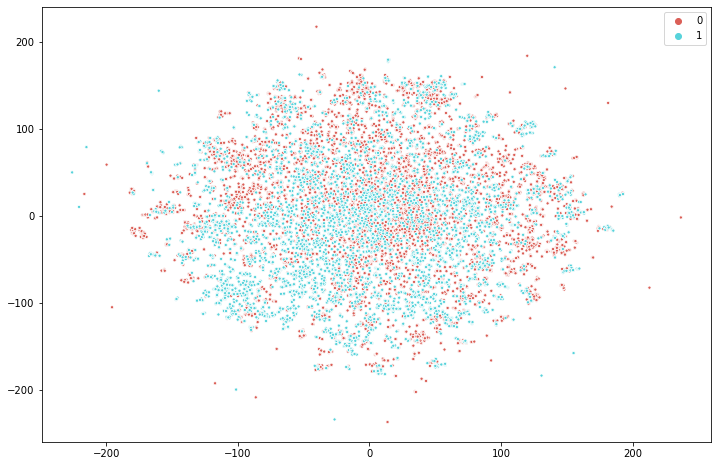

20


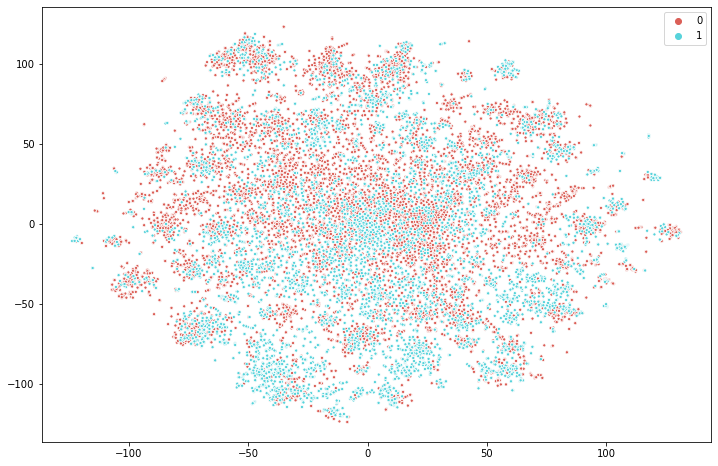

50


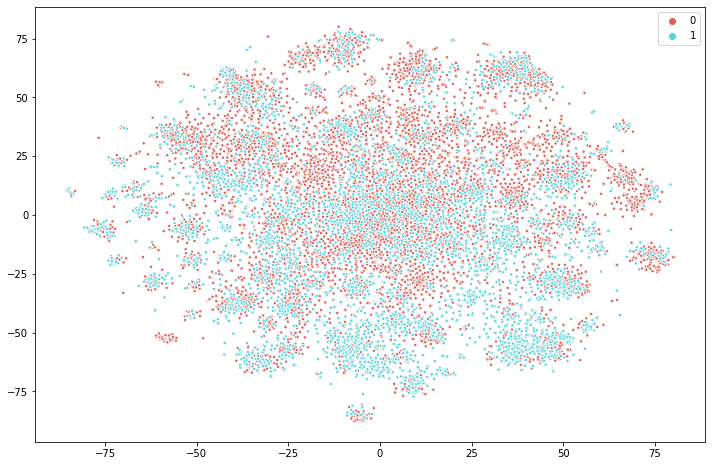

100


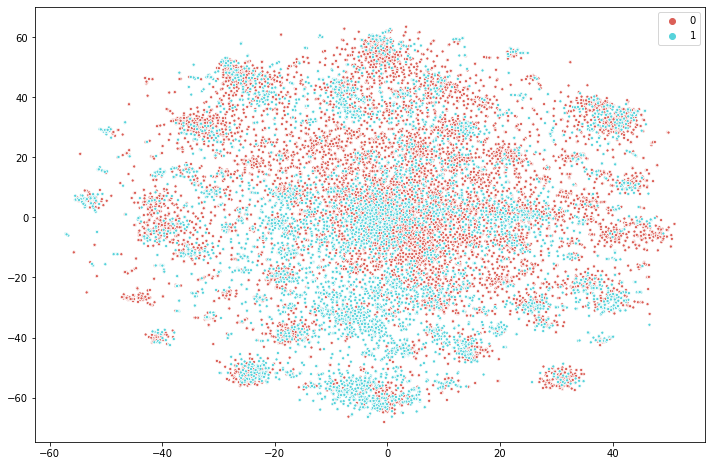

CPU times: user 1h 30min 28s, sys: 6min 19s, total: 1h 36min 47s
Wall time: 1h 25min 17s


In [79]:
%%time
perplexity = [5, 20, 50, 100]
for p in perplexity:
    tsne = TSNE(n_components=2, verbose=0, perplexity=p, n_iter=5000, learning_rate=50, random_state=33)
    r = tsne.fit_transform(dd)
    print(p)
    plt.figure(figsize=(12,8))
    sns.scatterplot(
        x=r[:, 0], y=r[:, 1],
        palette=sns.color_palette("hls", 2),
    #     legend="full",
        hue=h,
        s=10
    )
    plt.show()

In [116]:
ridero_topics.values

array([[0.        , 0.        , 0.        , ..., 0.01181102, 0.00393701,
        0.        ],
       [0.        , 0.00549451, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.01666667, 0.        , ..., 0.07222223, 0.        ,
        0.        ],
       ...,
       [0.02762463, 0.        , 0.        , ..., 0.0052356 , 0.0052356 ,
        0.        ],
       [0.01470588, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.0075188 , 0.        , 0.0075188 , ..., 0.        , 0.0075188 ,
        0.        ]], dtype=float32)

In [426]:
pd.Series(np.median(cd, axis=0)).describe()

count    5398.000000
mean        0.769005
std         0.011990
min         0.735219
25%         0.760797
50%         0.768677
75%         0.776837
max         0.809996
dtype: float64

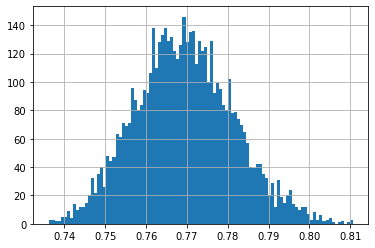

In [40]:
pd.Series(np.median(cd, axis=0)).hist(bins=100)

In [20]:
m._mystemargs = ['--format', 'json', '-gidwc']

In [50]:
from scripts import readability as rb
def readability_processor(text):
    text = m.analyze(text)
    pos_tags = rb.pos_tagger(text)
    pos_input = ' '.join(pos_tags)
    return np.array([
        *rb.pos_fraction(pos_tags),
        rb.type_token_ratio(text),
        rb.avg_sent_len(pos_input),
        rb.dialog_fraction(pos_input)
    ])

In [53]:
def get_texts_readability(texts):
    data = []
    for i, text in enumerate(texts):
        for j, chunk in enumerate(text_to_chunks(text)):
            data.append((i, j, readability_processor(chunk)))
    return pd.DataFrame(data, columns=['book', 'chunk', 'readability'])

In [54]:
%%time
polka_readability = get_texts_readability(polka_texts)
ridero_readability = get_texts_readability(ridero_texts)

else {'analysis': [], 'text': '¦'}
else {'analysis': [], 'text': '°'}
else {'analysis': [], 'text': '°'}
else {'analysis': [], 'text': '°'}
else {'analysis': [], 'text': '°'}
else {'analysis': [], 'text': '°'}
else {'analysis': [], 'text': '°'}
else {'analysis': [], 'text': '°'}
else {'analysis': [], 'text': '°'}
else {'analysis': [], 'text': '°'}
else {'analysis': [], 'text': '°'}
else {'analysis': [], 'text': '°'}
else {'analysis': [], 'text': '°'}
else {'analysis': [], 'text': '°'}
else {'analysis': [], 'text': '°'}
else {'analysis': [], 'text': '°'}
else {'analysis': [], 'text': '°'}
else {'analysis': [], 'text': '°'}
else {'analysis': [], 'text': '°'}
else {'analysis': [], 'text': '°'}
else {'analysis': [], 'text': '√'}
else {'analysis': [], 'text': '√'}
else {'analysis': [], 'text': '√'}
else {'analysis': [], 'text': '√'}
else {'analysis': [], 'text': '√'}
else {'analysis': [], 'text': '√'}
else {'analysis': [], 'text': '√'}
else {'analysis': [], 'text': '√'}
else {'analysis': []

else {'analysis': [], 'text': '✎'}
else {'analysis': [], 'text': '✎'}
else {'analysis': [], 'text': '✎'}
else {'analysis': [], 'text': '✎'}
else {'analysis': [], 'text': '✎'}
else {'analysis': [], 'text': '✎'}
else {'analysis': [], 'text': '✎'}
else {'analysis': [], 'text': '©'}
else {'analysis': [], 'text': '⠀'}
else {'analysis': [], 'text': '⠀'}
else {'analysis': [], 'text': '⠀'}
else {'analysis': [], 'text': '⠀'}
else {'analysis': [], 'text': '⠀'}
else {'analysis': [], 'text': '⠀'}
else {'analysis': [], 'text': '⠀'}
else {'analysis': [], 'text': '⠀'}
else {'analysis': [], 'text': '⠀'}
else {'analysis': [], 'text': '⠀'}
else {'analysis': [], 'text': '⠀'}
else {'analysis': [], 'text': '⠀'}
else {'analysis': [], 'text': '⠀'}
else {'analysis': [], 'text': '⠀'}
else {'analysis': [], 'text': '⠀'}
else {'analysis': [], 'text': '⠀'}
else {'analysis': [], 'text': '⠀'}
else {'analysis': [], 'text': '⠀'}
else {'analysis': [], 'text': '⠀'}
else {'analysis': [], 'text': '⠀'}
else {'analysis': []

else {'analysis': [], 'text': '⚃'}
else {'analysis': [], 'text': '⚀'}
else {'analysis': [], 'text': '⚁'}
else {'analysis': [], 'text': '⚂'}
else {'analysis': [], 'text': '⚃'}
else {'analysis': [], 'text': '⚄'}
else {'analysis': [], 'text': '⚅'}
else {'analysis': [], 'text': '⚄'}
else {'analysis': [], 'text': '⚀'}
else {'analysis': [], 'text': '⚁'}
else {'analysis': [], 'text': '⚂'}
else {'analysis': [], 'text': '⚃'}
else {'analysis': [], 'text': '⚄'}
else {'analysis': [], 'text': '⚅'}
else {'analysis': [], 'text': '⚅'}
else {'analysis': [], 'text': '⚀'}
else {'analysis': [], 'text': '⚁'}
else {'analysis': [], 'text': '⚂'}
else {'analysis': [], 'text': '⚃'}
else {'analysis': [], 'text': '⚄'}
else {'analysis': [], 'text': '⚅'}
else {'analysis': [], 'text': '⚀'}
else {'analysis': [], 'text': '⚀'}
else {'analysis': [], 'text': '⚁'}
else {'analysis': [], 'text': '⚂'}
else {'analysis': [], 'text': '⚃'}
else {'analysis': [], 'text': '⚄'}
else {'analysis': [], 'text': '⚅'}
else {'analysis': []

else {'analysis': [], 'text': '⚀'}
else {'analysis': [], 'text': '⚀'}
else {'analysis': [], 'text': '⚁'}
else {'analysis': [], 'text': '⚂'}
else {'analysis': [], 'text': '⚃'}
else {'analysis': [], 'text': '⚄'}
else {'analysis': [], 'text': '⚅'}
else {'analysis': [], 'text': '⚁'}
else {'analysis': [], 'text': '⚀'}
else {'analysis': [], 'text': '⚁'}
else {'analysis': [], 'text': '⚂'}
else {'analysis': [], 'text': '⚃'}
else {'analysis': [], 'text': '⚄'}
else {'analysis': [], 'text': '⚅'}
else {'analysis': [], 'text': '⚂'}
else {'analysis': [], 'text': '⚀'}
else {'analysis': [], 'text': '⚁'}
else {'analysis': [], 'text': '⚂'}
else {'analysis': [], 'text': '⚃'}
else {'analysis': [], 'text': '⚄'}
else {'analysis': [], 'text': '⚅'}
else {'analysis': [], 'text': '⚃'}
else {'analysis': [], 'text': '⚀'}
else {'analysis': [], 'text': '⚁'}
else {'analysis': [], 'text': '⚂'}
else {'analysis': [], 'text': '⚃'}
else {'analysis': [], 'text': '⚄'}
else {'analysis': [], 'text': '⚅'}
else {'analysis': []

else {'analysis': [], 'text': '⚂'}
else {'analysis': [], 'text': '⚃'}
else {'analysis': [], 'text': '⚄'}
else {'analysis': [], 'text': '⚅'}
else {'analysis': [], 'text': '⚃'}
else {'analysis': [], 'text': '⚀'}
else {'analysis': [], 'text': '⚁'}
else {'analysis': [], 'text': '⚂'}
else {'analysis': [], 'text': '⚃'}
else {'analysis': [], 'text': '⚄'}
else {'analysis': [], 'text': '⚅'}
else {'analysis': [], 'text': '⚄'}
else {'analysis': [], 'text': '⚀'}
else {'analysis': [], 'text': '⚁'}
else {'analysis': [], 'text': '⚂'}
else {'analysis': [], 'text': '⚃'}
else {'analysis': [], 'text': '⚄'}
else {'analysis': [], 'text': '⚅'}
else {'analysis': [], 'text': '⚅'}
else {'analysis': [], 'text': '⚀'}
else {'analysis': [], 'text': '⚁'}
else {'analysis': [], 'text': '⚂'}
else {'analysis': [], 'text': '⚃'}
else {'analysis': [], 'text': '⚄'}
else {'analysis': [], 'text': '⚅'}
else {'analysis': [], 'text': '⚀'}
else {'analysis': [], 'text': '⚀'}
else {'analysis': [], 'text': '⚁'}
else {'analysis': []

else {'analysis': [], 'text': '©'}
else {'analysis': [], 'text': '©'}
else {'analysis': [], 'text': '©'}
else {'analysis': [], 'text': '⠀'}
else {'analysis': [], 'text': '⠀'}
else {'analysis': [], 'text': '⠀'}
else {'analysis': [], 'text': '⠀'}
else {'analysis': [], 'text': '⠀'}
else {'analysis': [], 'text': '⠀'}
else {'analysis': [], 'text': '⠀'}
else {'analysis': [], 'text': '⠀'}
else {'analysis': [], 'text': '⠀'}
else {'analysis': [], 'text': '⠀'}
else {'analysis': [], 'text': '⠀'}
else {'analysis': [], 'text': '⠀'}
else {'analysis': [], 'text': '⠀'}
else {'analysis': [], 'text': '⠀'}
else {'analysis': [], 'text': '⠀'}
else {'analysis': [], 'text': '⁄'}
CPU times: user 5min 19s, sys: 1min 32s, total: 6min 51s
Wall time: 22min 17s


In [55]:
polka_readability.to_csv('polka_read.csv')
ridero_readability.to_csv('ridero_read.csv')

In [56]:
ridero_readability

book  chunk                                        readability
0        0      0  [0.05089820359281437, 0.03293413173652695, 0.0...
1        0      1  [0.053763440860215055, 0.03840245775729647, 0....
2        0      2  [0.04042715484363082, 0.03585049580472922, 0.0...
3        1      0  [0.07823392718822618, 0.037955073586367155, 0....
4        1      1  [0.060203283815480846, 0.04691164972634871, 0....
...    ...    ...                                                ...
8935  1924      0  [0.05634920634920635, 0.04285714285714286, 0.0...
8936  1924      1  [0.035545023696682464, 0.04344391785150079, 0....
8937  1924      2  [0.04482477587612062, 0.040749796251018745, 0....
8938  1924      3  [0.057211925866236905, 0.045124899274778404, 0...
8939  1924      4  [0.0665083135391924, 0.0498812351543943, 0.009...

[8940 rows x 3 columns]

'ДЕНЬ ПЕРВЫЙ \n Над городом стоял туман. Господин Новоселецкий лениво вылез из открытого экипажа, на заснеженную привокзальную площадь. Подошёл к одинокому фонарю, вынул из внутреннего кармана часы и вгляделся в циферблат: половина девятого. \n Запахнул плотнее пальто и шагнул к зданию. У крыльца поскользнулся, нелепо взмахнул руками и чуть не упал, выкрикнув крепкое словцо. \n Разозлившись, ввалился, держась за поясницу, внутрь вокзала и уверенно толкнул дверь коменданта. \n — Чего у тебя крыльцо не чищено? — заявил с порога. \n Фёдоров чуть не поперхнулся чаем. Подскочил из-за стола: \n — Митрофан Иванович! Доброго здоровья. \n — Будешь тут здоров; спину вот потянул, — проворчал тот, супя брови. \n — Сию минуту. Всё исправим, — засуетился комендант, выглядывая за дверь, — Митька!. \n Отдав распоряжения, вернулся с оправдательным выражением лица: \n — Весна нынче больно пакостная. Всё, что за день водой берётся, ночью льдом оборачивается. Не успеваем уследить. \n — Ладно зубы-то мне з

In [113]:
text_to_chunks(ridero_texts[0])[0]

'ДЕНЬ ПЕРВЫЙ Над городом стоял туман. Господин Новоселецкий лениво вылез из открытого экипажа, на заснеженную привокзальную площадь. Подошёл к одинокому фонарю, вынул из внутреннего кармана часы и вгляделся в циферблат: половина девятого. Запахнул плотнее пальто и шагнул к зданию. У крыльца поскользнулся, нелепо взмахнул руками и чуть не упал, выкрикнув крепкое словцо. Разозлившись, ввалился, держась за поясницу, внутрь вокзала и уверенно толкнул дверь коменданта. — Чего у тебя крыльцо не чищено? — заявил с порога. Фёдоров чуть не поперхнулся чаем. Подскочил из-за стола: — Митрофан Иванович! Доброго здоровья. — Будешь тут здоров; спину вот потянул, — проворчал тот, супя брови. — Сию минуту. Всё исправим, — засуетился комендант, выглядывая за дверь, — Митька!. Отдав распоряжения, вернулся с оправдательным выражением лица: — Весна нынче больно пакостная. Всё, что за день водой берётся, ночью льдом оборачивается. Не успеваем уследить. — Ладно зубы-то мне заговаривать. Скажи-ка лучше, моск

In [109]:
rb.pos_fraction(' '.join(rb.pos_tagger(m.analyze(text_to_chunks(ridero_texts[0])[0]))))

[0.03857457751653196,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.06943423952975752,
 0.0,
 0.040778839088905214,
 0.0,
 0.0,
 0.0,
 0.0]

In [124]:
%%time
cdr = cdist(np.stack(ridero_readability['readability'].values),
            np.stack(polka_readability['readability'].values), 
            metric=cosine)

KeyboardInterrupt: 

In [41]:
pd.Series(np.median(cdr, axis=0)).hist(bins=100)

NameError: name 'polka_texts' is not defined

In [16]:
m = Mystem()

In [17]:
m._mystemargs = ['--format', 'json', '-gidw']

In [124]:
m.analyze(t)[0]['analysis'][0]

{'lex': 'день', 'gr': 'S,муж,неод=(вин,ед|им,ед)'}

In [108]:
m.analyze(t)[0]['analysis'][0]

{'lex': 'день', 'gr': 'S,муж,неод=(вин,ед|им,ед)'}

In [115]:
len(mystem_processor(t).split())

254

In [ ]:
!bert-serving-start -model_dir ~/Projects/multi_cased_L-12_H-768_A-12/ -num_worker=1 -max_seq_len 128 -cased_tokenization

derevnya


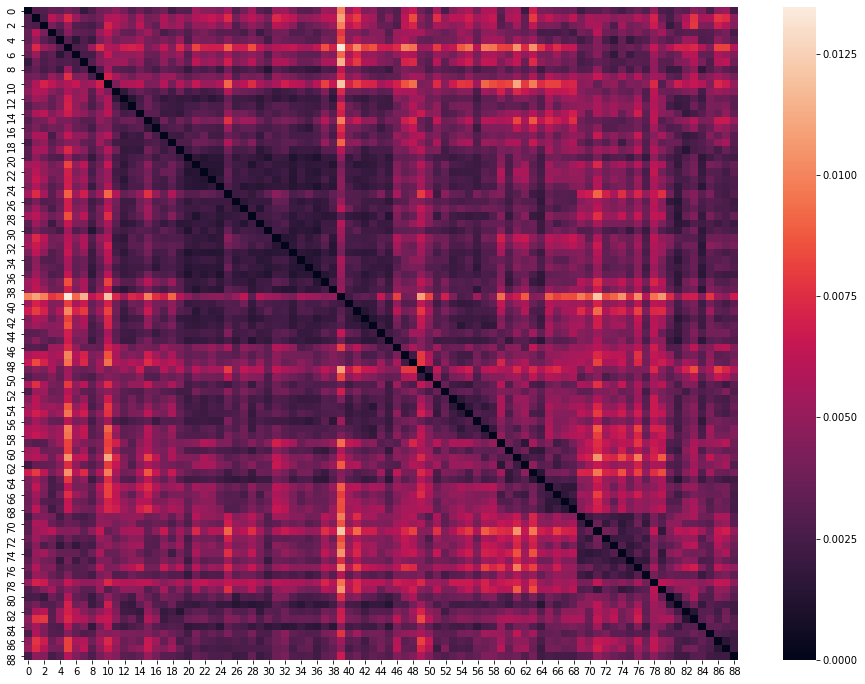

love


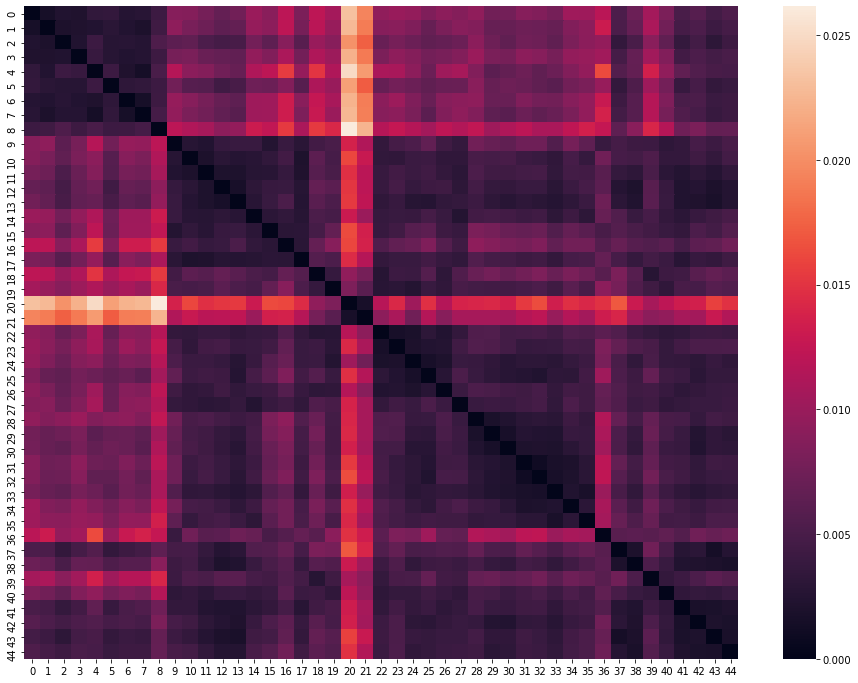

revolution


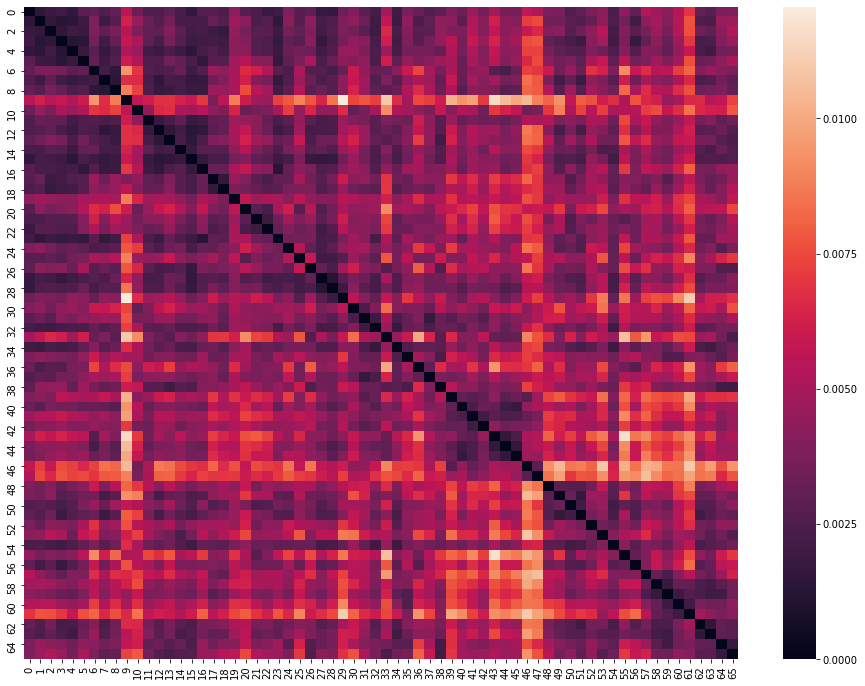

mix1


KeyboardInterrupt: 

In [68]:
for theme in ['derevnya', 'love', 'revolution', 'mix1', 'mix2', 'mix3', 'mix4', 'mix5']:
    print(theme)
    dir_in = 'test/' + theme
    texts = []
    for f in sorted(os.listdir(dir_in)):
        if f in ('wv.txt', 'chunks', 'batches', '.ipynb_checkpoints'):
            continue
        with open('../pb-stylistic/txt_cut/' + f + '.fb2.txt') as fi:
            texts.append(fi.read().replace('\n', ' '))
    text_chunks = []
    sentences = []
    labels = []
    i = 0
    for text in texts:
        tokens = text.split()
        n_chunks = len(tokens) // 1000
        cur_text_chunks = list(' '.join(ch) for ch in chunks(tokens, 1000) if len(ch) > 500)
        text_chunks.extend(cur_text_chunks)
        for t in cur_text_chunks:
            for chunk in chunks(t.split(), 128):
                labels.append(i)
                sentences.append(' '.join(chunk))
            i += 1
    labels = pd.Series(labels)
    embs = bc.encode(sentences)
    chunk_embs = []
    for label in labels.unique():
        chunk = embs[labels == label]
        chunk_embs.append(chunk.mean(axis=0))
    plt.figure(figsize=(16, 12))
    sns.heatmap(squareform(pdist(chunk_embs, metric='cosine')))
    plt.show()

In [166]:
import pickle
from tqdm.auto import tqdm

In [168]:
for f in tqdm(sorted(os.listdir('ridero_books'))):
    if f in os.listdir('ridero_books_emb'):
        continue
    with open('ridero_books/' + f) as fi:
        sentences = []
        text = fi.read()
        tokens = text.split()
        n_chunks = len(tokens) // 1000
        cur_text_chunks = list(' '.join(ch) for ch in chunks(tokens, 1000) if len(ch) > 500)
        for t in cur_text_chunks:
            for chunk in chunks(t.split(), 128):
                sentences.append(' '.join(chunk))
        if not sentences:
            print(f)
            continue
        emb = bc.encode(sentences).mean(axis=0)
        with open ('ridero_books_emb/' + f, 'wb') as fo:
            pickle.dump(emb, fo)

baby_in_spb_detka_v_pitere
barzhizn
bludniza
dolg_palacha
ekho_prokurennykh_podezdov
gde_zhe_ty_edinorog
gremlinskii_ostrov
kak_perestat_sidet_i_poiti_prilech
kambodzhiiskie_khroniki
khanoiskaya_bashnya
khaski_s_alyaski
khroniki_bolshogo_goroda
kladka_stalnoi_pticy
koldovskoi_meshok
kolybel_ikhtisa
korotko_i_yasno
krivaya_sudby
kto_ograbil_bukvu_a
ktoito_v_etoi_afrike_polosatyi_skachet
kupalnye_istorii
lenin_zhiv
mechty_sbyvayutsya_2
ochen_vkusnye_stikhi
onkologiya_i_gory
otdykhali_turisty_v_lesu
pamyat_6
podaite_poetu
portret_starogo_grafa
priklyucheniya_snezhika
prodelki_sudby
ryzhie_angely
skazanie_o_tarre
skazka_pro_vozdushnykh_rozovykh_slonov
skazki-obrazovashki
skazki_novogo_vremeni
velosiped_1
vinnyi_sklep
voennyj_gorodok_trudovaya
volshebnye_khroniki
ya_tebya_zhdu_ochen
zaika_oi_i_belchonok_tyu
zhalko
zhittya_sered_khmar



In [373]:
gdr = []
for b1 in polka_chunks.book.unique():
    dr = []
    q1 = np.stack(polka_chunks[polka_chunks.book == b1]['bert'])
    for b2 in ridero_chunks.book.unique():
        q2 = np.stack(ridero_chunks[ridero_chunks.book == b2]['bert'])
        dr.append(cdist(q1, q2, metric=cosine).mean())
    gdr.append(dr)

In [172]:
for f in tqdm(sorted(os.listdir('txt_cut'))):
    if f in os.listdir('txt_cut_emb'):
        continue
    with open('txt_cut/' + f) as fi:
        sentences = []
        text = fi.read()
        tokens = text.split()
        n_chunks = len(tokens) // 1000
        cur_text_chunks = list(' '.join(ch) for ch in chunks(tokens, 1000) if len(ch) > 500)
        for t in cur_text_chunks:
            for chunk in chunks(t.split(), 128):
                sentences.append(' '.join(chunk))
        if not sentences:
            print(f)
            continue
        emb = bc.encode(sentences).mean(axis=0)
        with open ('txt_cut_emb/' + f, 'wb') as fo:
            pickle.dump(emb, fo)

In [287]:
labels[labels.book == 7]

book  chunk                                           sentence  \
225     7      0  От автора Дорогой читатель! Я не смогу ответит...   
226     7      0  слово «море» ни одного человека не сможет оста...   
227     7      0  думаешь, представляешь, вспоминаешь…. Благодар...   
228     7      0  что сам чуть не упал…. Вот тогда было по-насто...   
229     7      0  строки. Опять в окно. Там — лес, тот же и немн...   
..    ...    ...                                                ...   
340     7     14  иногда это придется скрывать…. Так устроено в ...   
341     7     14  натуры, а просто объяснил, что другим быть не ...   
342     7     14  они вместе обсуждали историю, которой их учил ...   
343     7     14  был ему нужнее всего. Разговоры друзей все чащ...   
344     7     14  только и смог вымолвить Дима. Потом резко засо...   

                                                  bert  
225  [0.3725749, 0.1099168, -0.29413277, 0.21634434...  
226  [0.43093288, -0.021979922, -0.042688068, 0.247...  
227  [0.12088561, 0.14619811, -0.26351982, 0.112240...  
228  [0.45641622, 0.1437684, -0.2058486, 0.22260164...  
229  [0.34564242, 0.18933685, -0.37634486, 0.102031...  
..                                                 ...  
340  [0.08359307, -0.23885517, -0.14792179, 0.15237...  
341  [0.23553939, -0.16708422, 0.04482049, 0.189792...  
342  [0.020755125, -0.11169502, 0.027010623, 0.1817...  
343  [0.2565583, -0.042259775, 0.16178924, 0.086489...  
344  [0.2813574, -0.45094413, -0.29157487, 0.286454...  

[120 rows x 4 columns]

In [ ]:
x1 x2 x3
y1 y2
(cos(x1, y1) + cos(x1, y2) ) / 2

In [181]:
ridero_embs = []
for f in tqdm(sorted(os.listdir('ridero_books_emb'))):
    with open('ridero_books_emb/' + f, 'rb') as fi:
        ridero_embs.append(pickle.load(fi))

In [374]:
gdr

[[0.006050122332453656,
  0.005176667224003269,
  0.00548672966769059,
  0.007516291933849006,
  0.006557509378137054,
  0.004349828062657073,
  0.007013626637138623,
  0.006084693659013719,
  0.005939133015401915,
  0.005899295193770344],
 [0.00411302126618445,
  0.004627647842903408,
  0.0069572040942386315,
  0.006352570305898869,
  0.0053533740210397526,
  0.004648123592089521,
  0.007007241988705455,
  0.007108920580619362,
  0.0076701997065696335,
  0.0071246225255858706],
 [0.00394249606420967,
  0.004364413850435129,
  0.005886672215820591,
  0.006332282743448113,
  0.00589601378758648,
  0.00419049074727106,
  0.0063066082376450295,
  0.006135767238807302,
  0.006637712068434175,
  0.006271096946076889],
 [0.006911852002818318,
  0.007104686175137047,
  0.007486750276551479,
  0.00998179928796928,
  0.008486488789331321,
  0.006339710650620657,
  0.008363508011155719,
  0.0078093202794709835,
  0.007896262824219735,
  0.007451773858423211],
 [0.007731172434089174,
  0.00721592

In [58]:
with open('../pb-stylistic/txt_cut/96350.fb2.txt') as book:
    text = book.read()

In [180]:
polka_embs = []
for f in tqdm(sorted(os.listdir('txt_cut_emb'))):
    with open('txt_cut_emb/' + f, 'rb') as fi:
        polka_embs.append(pickle.load(fi))

In [183]:
from scipy.spatial.distance import *

In [186]:
ridero_pdist = pdist(ridero_embs, metric='cosine')

In [189]:
pd.Series(ridero_pdist).describe()

count    1.770021e+06
mean     4.820902e-03
std      3.399968e-03
min      1.110223e-16
25%      2.772653e-03
50%      3.899053e-03
75%      5.694861e-03
max      5.637427e-02
dtype: float64

In [202]:
2.7e-03

0.0027

In [56]:
import pandas as pd

In [77]:
%%time
embs = bc.encode(text_to_sentences(text) * 5)

CPU times: user 25.5 ms, sys: 2.51 ms, total: 28 ms
Wall time: 1min 9s


In [67]:
%%time
for s in text_to_sentences(text):
    emb = bc.encode([s])

CPU times: user 36.8 ms, sys: 10.5 ms, total: 47.3 ms
Wall time: 1min 47s


In [190]:
cross_dist = cdist(ridero_embs, polka_embs, metric='cosine')pd.Series(ridero_pdist).describe()

In [191]:
cross_dist.shape

(1882, 621)

In [201]:
pd.Series(cross_dist.ravel()).describe()

count    1.168722e+06
mean     4.517601e-03
std      2.713287e-03
min      4.416438e-04
25%      2.874958e-03
50%      3.895392e-03
75%      5.348819e-03
max      3.625113e-02
dtype: float64

In [203]:
2.9e-04

0.00029

In [294]:
for g in polka_chunks.groupby('book'):
    print(mydist(g))
    break

/home/artesby/anaconda3/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  


TypeError: unhashable type: 'numpy.ndarray'

In [207]:
cross_dist[0].argsort()

array([155, 577, 106, 337, 284,  93, 556,  68, 611,   2, 165,   1, 100,
       162, 483, 203, 266, 505, 164,  67, 456, 256, 513,  91, 407, 264,
       372, 601, 273,  57, 609, 354, 480,  94, 160, 324, 619, 166, 545,
       371,  49, 359, 167,  26, 101, 143,  46,  98,  41, 482, 551, 381,
       107, 154, 242, 313, 464, 518, 497, 326, 299,   9,   6, 150, 524,
         5, 361, 147, 535,  60, 527, 315, 580,   8, 510, 105, 215, 291,
       474, 598, 270, 128, 595, 132, 373, 476, 224, 214, 589,  80,  39,
       265, 336, 362, 220, 173, 278, 427, 149, 563,  99, 415, 544, 262,
       590, 257, 613, 157, 606, 576, 587, 410, 244, 181, 219, 250, 145,
        89, 153, 216, 251, 608, 222, 119, 139, 356, 332, 120,   0, 109,
       238, 115, 550, 584, 365, 289, 218, 298, 269, 558,  44, 511, 193,
       343, 367, 180, 348,  96, 368, 102, 369, 491,  74,  37, 477, 471,
       575, 217, 496, 136, 159, 189, 591, 455, 114, 113, 309, 290, 559,
       287, 582,  61,  51, 574, 286,  48, 525, 486, 487, 594, 38

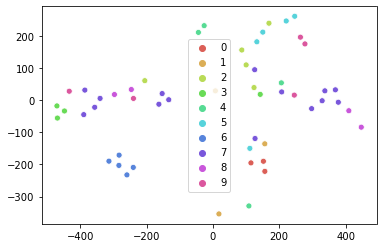

In [232]:
r[0]

array([ 114.59375, -195.359  ], dtype=float32)

[0,
 0,
 0,
 1,
 1,
 1,
 2,
 2,
 2,
 2,
 2,
 3,
 3,
 3,
 3,
 4,
 4,
 4,
 4,
 5,
 5,
 5,
 5,
 5,
 6,
 6,
 6,
 6,
 6,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 8,
 8,
 8,
 8,
 9,
 9,
 9,
 9,
 9]

In [212]:
r[:, 0]

array([ -10.755159 ,    5.3882294,   -2.6577961,   51.7481   ,
         -4.7750845,  -21.714325 ,   17.19164  ,    7.434028 ,
        -61.565926 ,   12.494001 ,   41.853516 ,  -25.680202 ,
         45.12599  ,   30.242498 ,  -75.05593  ,  -59.60307  ,
        -22.970514 ,  -10.901392 ,   15.228175 ,   86.06086  ,
         -9.198769 ,   38.51709  ,   59.006313 ,   61.07901  ,
        -70.38634  ,  -36.942734 ,   13.888949 ,  -52.80905  ,
        -39.79189  ,   84.359535 ,   34.14663  ,  -55.56967  ,
        -44.347855 ,  -81.63338  ,   -6.3582144,   15.000217 ,
        -33.219246 ,   27.156336 ,  -28.781216 ,  -34.740932 ,
        -13.743    ,  -48.46812  ,   25.26955  ,   54.718914 ,
         -0.6265781,  -18.675287 , -110.90717  ,  -52.50213  ,
          7.341235 ,   -7.6936526,  -36.776314 ,   39.535503 ,
         20.656437 ], dtype=float32)

In [204]:
tsne_pca_results

array([[ 2.2792037e+00,  4.8688240e+01],
       [-5.8201454e+01,  3.5168541e+01],
       [ 1.6076713e+00,  6.9109062e+01],
       [ 2.2185934e+01,  4.8325821e+01],
       [ 1.9459648e+01,  1.2630428e+01],
       [ 4.9297398e+01,  1.6101892e+01],
       [ 5.6957005e+01, -5.6745274e+01],
       [-3.5223713e+01,  1.8638750e+01],
       [ 3.9419472e+01,  1.4702488e+00],
       [ 2.8849900e-02,  9.2009172e+00],
       [ 6.6359520e+01,  2.1910851e+01],
       [ 2.3969374e+01, -3.8700631e+00],
       [ 8.9236298e+00, -6.8399605e+01],
       [-5.0778599e+01, -5.1697060e+01],
       [-1.4320902e+00, -5.0361133e+00],
       [ 4.3645115e+01,  4.1622021e+01],
       [ 1.1514204e+01, -1.2387953e+01],
       [-9.0567513e+00,  2.8720055e+01],
       [ 3.3293434e+01, -5.0566856e+01],
       [ 3.3136799e+01,  2.4162321e+01],
       [ 5.2170019e+00,  2.3326801e+01],
       [-5.6053547e+01, -1.9248775e+01],
       [-7.0229790e+01,  1.5839361e+01],
       [-2.1284248e+01,  6.5161324e+01],
       [-1.66965

In [185]:
impprt tsne

SyntaxError: invalid syntax (<ipython-input-185-eb0e30e399c4>, line 1)